In [ ]:
!pip install transformers
!pip install datasets
!pip install tez
!pip install labels

     |████████████████████████████████| 2.8 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 32.5 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 3.3 MB 35.7 MB/s 
     |████████████████████████████████| 895 kB 42.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 270 kB 3.9 MB/s 
     |████████████████████████████████| 1.3 MB 43.9 MB/s 
     |████████████████████████████████| 123 kB 53.2 MB/s 
     |████████████████████████████████| 243 kB 54.2 MB/s 
     |████████████████████████████████| 142 kB 53.7 MB/s 
     |████████████████████████████████| 294 kB 57.1 MB/s 


In [ ]:
from datasets import load_dataset
from labels1 import mapping

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
go_emotions = load_dataset("go_emotions")

data = go_emotions.data

train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

print(train.shape, valid.shape, test.shape)
# (43410, 31) (5426, 31) (5427, 31)

Downloading:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

No config specified, defaulting to: go_emotions/simplified


Downloading:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/203k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/201k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

(43410, 3) (5426, 3) (5427, 3)


In [ ]:
train.head(10)

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,[26],edvnz26
6,Yes I heard abt the f bombs! That has to be wh...,[15],ee3b6wu
7,We need more boards and to create a bit more s...,"[8, 20]",ef4qmod
8,Damn youtube and outrage drama is super lucrat...,[0],ed8wbdn
9,It might be linked to the trust factor of your...,[27],eczgv1o


In [ ]:
n_labels = len(mapping)

def one_hot_labels(df):
    dict_labels = []
    for i in tqdm(range(len(df)), leave=False):
        d = dict(zip(range(n_labels), [0]*n_labels))
        labels = df.loc[i]["labels"]
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
    df_labels = pd.DataFrame(dict_labels)
    return df_labels


In [ ]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [ ]:
train_oh_labels.shape

(43410, 28)

In [ ]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

In [ ]:
train_oh_labels.shape

(43410, 28)

In [ ]:
print(train.shape, valid.shape, test.shape)

(43410, 31) (5426, 31) (5427, 31)


In [ ]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


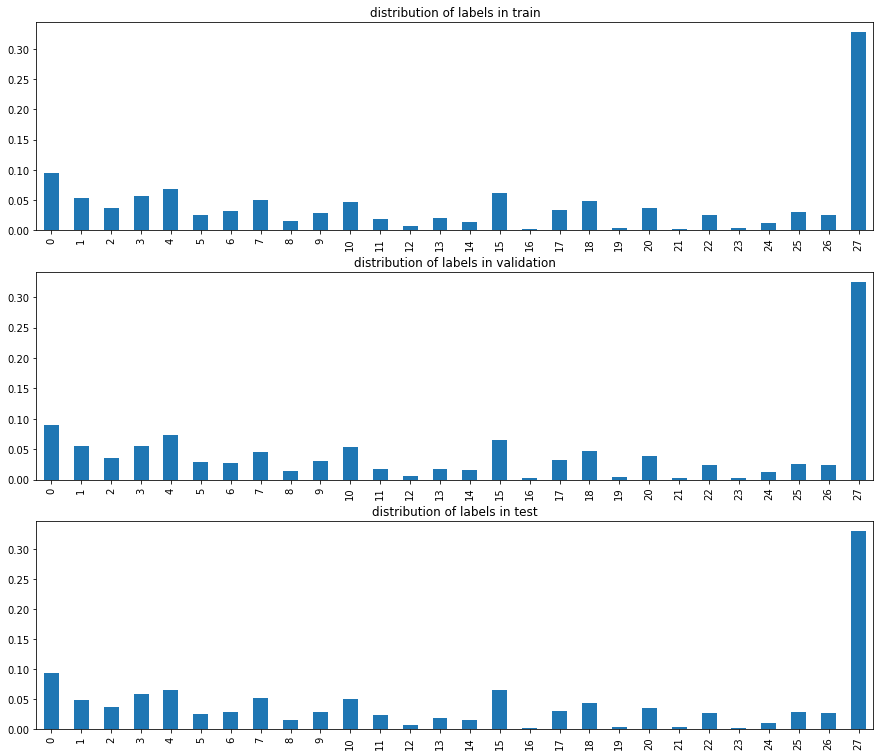

In [ ]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [ ]:
def inspect_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]

    print(f"examples from {sentiment}")
    print()
    for text in samples["text"]:
        print(text)
        print("---")

In [ ]:
inspect_data(0)

examples from admiration

It was so great to have a nice friendly NPC like that. Just one student that didn't hate our guts.
---
It was pretty cool seeing him play all the horrible games based off his childhood stardom on AVGN’s YouTube channel. Fucking [NAME].... Bane of my childhood.
---
Its worth it for the other big character they bring in.
---
From Rockledge, Florida in the united states. Don't know why I ended up here to be honest but it's a good time.
---
Genuinely fascinating.
---


In [ ]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)
        self.max_len = 35

    def __len__(self):
        return len(self.texts)


    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]

        inputs = self.tokenizer.encode_plus(text,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

In [ ]:
class EmotionClassifier(tez.Model):
    def __init__(self, num_train_steps, num_classes):
        super().__init__()
        self.bert = transformers.RobertaModel.from_pretrained('roberta-base')
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"

    def fetch_optimizer(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        opt = AdamW(optimizer_parameters, lr=3e-5)
        return opt


    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=0, num_training_steps=self.num_train_steps
        )
        return sch

    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.BCEWithLogitsLoss()(outputs, targets.float())


    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}

        outputs = torch.sigmoid(outputs)
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()

        fpr_micro, tpr_micro, _ = metrics.roc_curve(targets.ravel(), outputs.ravel())
        auc_micro = metrics.auc(fpr_micro, tpr_micro)
        return {"auc": auc_micro}


    def forward(self, ids, mask, targets=None):
        o_2 = self.bert(ids, attention_mask=mask)["pooler_output"]
        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc

In [ ]:
train_dataset = GoEmotionDataset(train.text.tolist(), train[range(n_labels)].values.tolist())
valid_dataset = GoEmotionDataset(valid.text.tolist(), valid[range(n_labels)].values.tolist())

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# device = torch.device("cuda")
#n_train_steps = int(len(train) / 32 * 10)
#model = EmotionClassifier(n_train_steps, n_labels)
model = torch.load("modelrob.bin")
model.eval()
# model.load_state_dict(torch.load("modelrob.bin", map_location="cuda"))
#tb_logger = tez.callbacks.TensorBoardLogger(log_dir="logs/")
#es = tez.callbacks.EarlyStopping(monitor="valid_loss", model_path="modelrob.bin")

# model.fit(train_dataset,
#           valid_dataset,
#           train_bs=64,
#           device="cuda",
#           epochs=1,
#           callbacks=[tb_logger, es],
#           fp16=True,
#           n_jobs=10)


AttributeError: ignored

In [ ]:
test_dataset = GoEmotionDataset(test.text.tolist(), test[range(n_labels)].values.tolist())
dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

In [ ]:
outputs = []

with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        output, loss, acc = model.forward(batch["ids"].to("cuda"),
                                          batch["mask"].to("cuda"),
                                          #batch["token_type_ids"].to("cuda"),
                                          batch["targets"].to("cuda")
                                         )
        outputs.append(output)

  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
outputs = torch.cat(outputs)
outputs = torch.sigmoid(outputs)
outputs = outputs.cpu().detach().numpy()

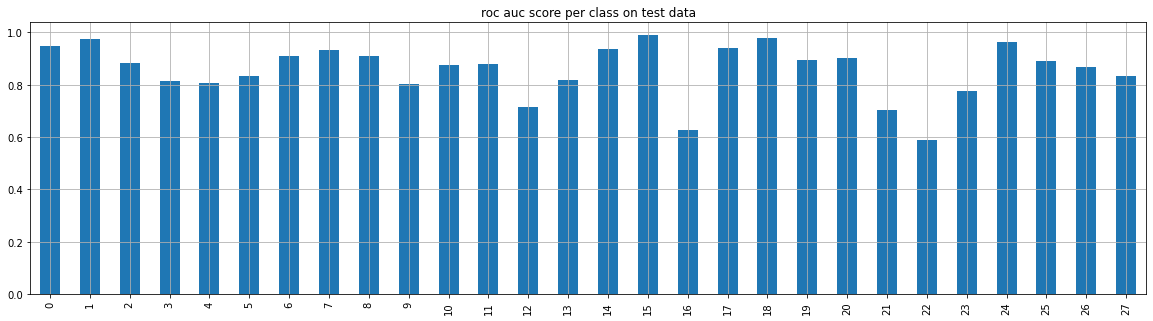

In [ ]:
roc_metrics = []

for i in range(n_labels):
    roc = metrics.roc_auc_score(test[i].values, outputs[:, i])
    roc_metrics.append(roc)

s = pd.Series(roc_metrics, index=range(n_labels))

s.plot(kind="bar", figsize=(20, 5), title="roc auc score per class on test data", grid=True)

In [ ]:
tokenizer = transformers.RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

In [ ]:
def score_sentence(text, topn=27):
    max_len = 35
    with torch.no_grad():

        inputs = tokenizer.encode_plus(text,
                                       None,
                                       add_special_tokens=True,
                                       max_length=max_len,
                                       padding="max_length",
                                       truncation=True)
        ids = inputs["input_ids"]
        ids = torch.LongTensor(ids).cuda().unsqueeze(0)

        attention_mask = inputs["attention_mask"]
        attention_mask = torch.LongTensor(attention_mask).cuda().unsqueeze(0)

        output = model.forward(ids, attention_mask)[0]
        output = torch.sigmoid(output)

        probas, indices = torch.sort(output)

    probas = probas.cpu().numpy()[0][::-1]
    indices = indices.cpu().numpy()[0][::-1]

    for i, p in zip(indices[:topn], probas[:topn]):
        print(mapping[i], p)

In [ ]:
score_sentence("Why the hell is my head hurting so bad")

anger 0.21564603
annoyance 0.129416
sadness 0.12894233
disappointment 0.103899986
disgust 0.07911293
surprise 0.06062829
fear 0.059628867
neutral 0.058438994
disapproval 0.040602185
curiosity 0.03980531
confusion 0.034293514
admiration 0.030604571
remorse 0.0293119
realization 0.028053693
amusement 0.024209661
love 0.020121556
caring 0.020120446
embarrassment 0.0192211
excitement 0.019013595
desire 0.016739145
nervousness 0.01650213
joy 0.015106845
approval 0.014828535
optimism 0.014556091
gratitude 0.01441076
pride 0.009354561
grief 0.009349542


In [ ]:
device = torch.device("cuda")
model.to(device)
torch.save(model.state_dict(),"modelrob1test.bin")